<h1><center>Shopper Profile</center></h1>

* Bu notebook Traditional Channel'da İstanbuldaki shopper profile'ları bulmak için hier. clustering'in kullanıldığı bir çalışmadır.

In [1]:
# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import sklearn
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
df = pd.read_csv('data/shopper_profile(2).csv')

In [3]:
df.head()

,outletnumber,outletname,geometry,MAIN_CHANNEL,SES,YAS_CLUSTER,HANE_BUYUKLUGU,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9332702,NASIP TICARET,POINT(28.96431721 41.01946082),MODERN RETAIL,C2,SIFIR,0.0,0,0,1.671144,...,NaN,NaN,NaN,NaN,501.095,6.970,NaN,NaN,58.135,NaN
1,9275447,OKKES OZDEMIR,POINT(28.96568156 41.0187091099999),ON-PREMISE,C2,SIFIR,0.0,0,0,1.671144,...,NaN,2.535,274.785,0.697,5.493,42.584,NaN,NaN,6.342,NaN
2,9559472,IHE EKMEK,POINT(28.9654682669789 41.0189375979826),TRADITIONAL RETAIL,C2,SIFIR,0.0,0,0,1.671144,...,NaN,NaN,42.280,NaN,17.436,7.667,NaN,NaN,NaN,NaN
3,9330002,ANADOLU BUFE,POINT(28.96676756 41.01845508),TRADITIONAL RETAIL,C2,SIFIR,0.0,0,0,1.671144,...,NaN,NaN,NaN,NaN,10.039,35.937,33.206,NaN,34.234,2.642
4,9333702,TADIM BUFE,POINT(28.96447361 41.0193937000001),TRADITIONAL RETAIL,C2,SIFIR,0.0,0,0,1.671144,...,NaN,NaN,2.113,NaN,22.717,39.759,2.250,NaN,7.184,5.284


## EDA

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53309 entries, 0 to 53308
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   outletnumber        53309 non-null  int64  
 1   outletname          53309 non-null  object 
 2   geometry            53309 non-null  object 
 3   MAIN_CHANNEL        53309 non-null  object 
 4   SES                 53309 non-null  object 
 5   YAS_CLUSTER         53309 non-null  object 
 6   HANE_BUYUKLUGU      53309 non-null  float64
 7   GUNDUZ_NUFUS        53309 non-null  int64  
 8   GECE_NUFUS          53309 non-null  int64  
 9   ZENGINLIK_INDEKSI   53309 non-null  float64
 10  SEHIRLESME_INDEKSI  53309 non-null  float64
 11  YAYA_TRAFIGI        53309 non-null  float64
 12  AYLIK_HARCAMA       53309 non-null  int64  
 13  GIDAVEICECEK_ORAN   53309 non-null  int64  
 14  ALKOLTUTUN_ORAN     53309 non-null  int64  
 15  EGLENCEKULTUR_ORAN  53309 non-null  int64  
 16  LOKA

In [5]:
df.MAIN_CHANNEL.unique()

array(['MODERN RETAIL', 'ON-PREMISE', 'TRADITIONAL RETAIL', 'E-COMMERCE',
       'OTHER/THIRD PARTY', 'DISCOUNTER'], dtype=object)

In [6]:
df.outletnumber.nunique()

53309

In [7]:
df['outletnumber'] = df['outletnumber'].astype(object)

In [8]:
df = df.query("MAIN_CHANNEL == 'TRADITIONAL RETAIL'").reset_index(drop=True)

In [9]:
# Bu dataframe üstünde oynama yapılmamış ana datadır.
df.outletnumber.nunique()

25104

#### Gece/Gündüz Oranı

In [10]:
# bu dataframe, model için kullanılacak dataframe'dir
model_data = df.copy()

In [11]:
# model_data['GECE_NUFUS'].replace({0: 0.00001}, inplace=True)
# model_data['GUNDUZ_NUFUS'].replace({0: 0.00001}, inplace=True)

In [12]:
# g = model_data[['GUNDUZ_NUFUS','GECE_NUFUS']]

In [13]:
# model_data["gündüz_gece_oran"] = g["GUNDUZ_NUFUS"]/g["GECE_NUFUS"]

In [14]:
# model_data.head(3)

In [15]:
def gece_gündüz(df):
    
    outletnumbers = df.outletnumber.unique()
    outletnumbers_list = outletnumbers.tolist()
    gece_gündüz_list = []
    
    for i in range(len(outletnumbers)):
        
        outlets = df.loc[df["outletnumber"] == outletnumbers[i]]
        
        if (outlets["GUNDUZ_NUFUS"].iloc[0]>=outlets["GECE_NUFUS"].iloc[0]):
            gece_gündüz_list.append("1")
        else:
            gece_gündüz_list.append("-1")
            
    gece_gündüz_df = pd.DataFrame(gece_gündüz_list)       
    result = pd.concat([df, gece_gündüz_df], axis=1)
    
    return(result)

In [16]:
model_data = model_data[[       
"outletnumber"
,"SES"           
,"YAS_CLUSTER"
,"HANE_BUYUKLUGU"
,"ZENGINLIK_INDEKSI"
,"AYLIK_HARCAMA"   
,"ALKOLTUTUN_ORAN"      
,"EGLENCEKULTUR_ORAN"   
,"LOKANTAOTEL_ORAN" 
,"EGITIM"
,"UNIVERSITE"
,"KULTUREL"          
,"ORTA_UST"
]]

In [17]:
model_data

,outletnumber,SES,YAS_CLUSTER,HANE_BUYUKLUGU,ZENGINLIK_INDEKSI,AYLIK_HARCAMA,ALKOLTUTUN_ORAN,EGLENCEKULTUR_ORAN,LOKANTAOTEL_ORAN,EGITIM,UNIVERSITE,KULTUREL,ORTA_UST
0,9559472,C2,SIFIR,0.000000,1.671144,4093,0,0,0,0,0,0,0
1,9330002,C2,SIFIR,0.000000,1.671144,4093,0,0,0,2,0,0,0
2,9333702,C2,SIFIR,0.000000,1.671144,4093,0,0,0,0,0,0,0
3,9310577,C2,SIFIR,0.000000,1.735001,4093,0,0,0,0,0,0,0
4,9631642,C2,SIFIR,0.000000,1.735001,4093,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25099,10626834,E,YOUNG,2.864283,0.295000,1172,5,2,6,0,0,0,0
25100,9606656,E,YOUNG,2.864283,0.295000,1172,5,2,6,0,0,0,0
25101,9009366,E,YOUNG,2.864283,0.295000,1172,5,2,6,0,0,0,0
25102,9359402,E,YOUNG,2.864283,0.295000,1172,5,2,6,0,0,0,0


In [18]:
# Get one label encoding of column "SES"
model_data["SES"] = model_data["SES"].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1})

In [19]:
# Get one label encoding of column "SES"
model_data["YAS_CLUSTER"] = model_data["YAS_CLUSTER"].replace({'SIFIR': 1, 'TEEN': 2, 'YOUNG': 3, 'YOUNG ADULT': 4, 'ADULT': 5, 'MIDDLE AGED': 6, 'OLD': 7})

In [20]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25104 entries, 0 to 25103
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   outletnumber        25104 non-null  object 
 1   SES                 25104 non-null  int64  
 2   YAS_CLUSTER         25104 non-null  int64  
 3   HANE_BUYUKLUGU      25104 non-null  float64
 4   ZENGINLIK_INDEKSI   25104 non-null  float64
 5   AYLIK_HARCAMA       25104 non-null  int64  
 6   ALKOLTUTUN_ORAN     25104 non-null  int64  
 7   EGLENCEKULTUR_ORAN  25104 non-null  int64  
 8   LOKANTAOTEL_ORAN    25104 non-null  int64  
 9   EGITIM              25104 non-null  int64  
 10  UNIVERSITE          25104 non-null  int64  
 11  KULTUREL            25104 non-null  int64  
 12  ORTA_UST            25104 non-null  int64  
dtypes: float64(2), int64(10), object(1)
memory usage: 2.5+ MB


#### Scaling and Normal Dist.

In [21]:
model_df = model_data.copy()

In [22]:
model_data = model_data.replace(np.nan,0)

In [23]:
model_data.clip(lower=0, inplace=True)

In [24]:
model_data.replace({0: 0.00001}, inplace=True)

In [25]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in data.columns:
        data[col] = min_max_scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [26]:
def normal_dist(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: boxcox1p(x,0.25))
        stats.boxcox(data[col])[0]
    return data

In [27]:
# Normal Dist.
model_df["SES"] = stats.boxcox(model_data["SES"])[0]
model_df["YAS_CLUSTER"] = stats.boxcox(model_data["YAS_CLUSTER"])[0]
model_df["HANE_BUYUKLUGU"] = stats.boxcox(model_data["HANE_BUYUKLUGU"])[0]      
model_df["ZENGINLIK_INDEKSI"] = stats.boxcox(model_data["ZENGINLIK_INDEKSI"])[0]   
model_df["AYLIK_HARCAMA"] = stats.boxcox(model_data["AYLIK_HARCAMA"])[0]       
#model_df["GIDAVEICECEK_ORAN"] = stats.boxcox(model_data["GIDAVEICECEK_ORAN"])[0]   
model_df["ALKOLTUTUN_ORAN"] = stats.boxcox(model_data["ALKOLTUTUN_ORAN"])[0]     
model_df["EGLENCEKULTUR_ORAN"] = stats.boxcox(model_data["EGLENCEKULTUR_ORAN"])[0]  
model_df["LOKANTAOTEL_ORAN"] = stats.boxcox(model_data["LOKANTAOTEL_ORAN"])[0]    
model_df["EGITIM"] = stats.boxcox(model_data["EGITIM"])[0]              
model_df["UNIVERSITE"] = stats.boxcox(model_data["UNIVERSITE"])[0]          
#model_df["ORTA"] = stats.boxcox(model_data["ORTA"])[0]                
#model_df["ORTA_ALT"] = stats.boxcox(model_data["ORTA_ALT"])[0]            
model_df["ORTA_UST"] = stats.boxcox(model_data["ORTA_UST"])[0]    
model_df["KULTUREL"] = stats.boxcox(model_data["KULTUREL"])[0]   

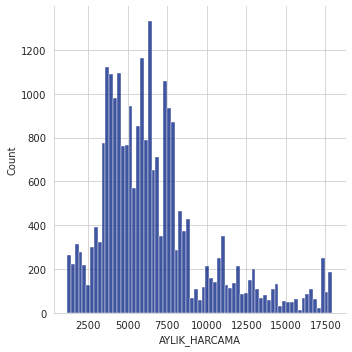

In [28]:
# original value
sns.displot(model_data["AYLIK_HARCAMA"])

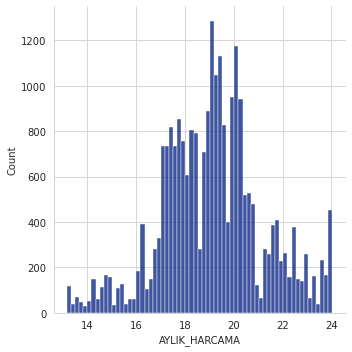

In [29]:
# original to normal dist. 
sns.displot(model_df["AYLIK_HARCAMA"])

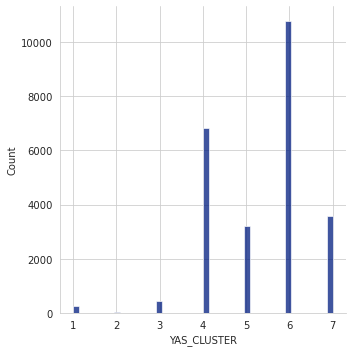

In [30]:
# normal dist. to scaling
sns.displot(model_data["YAS_CLUSTER"])

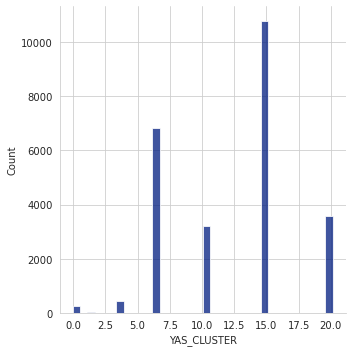

In [31]:
# normal dist. to scaling
sns.displot(model_df["YAS_CLUSTER"])

#### Scaling Part

In [32]:
model_df = scale_data(model_df)

In [33]:
model_df.YAS_CLUSTER.describe()

count    25104.000000
mean         0.620327
std          0.241761
min          0.000000
25%          0.331817
50%          0.741643
75%          0.741643
max          1.000000
Name: YAS_CLUSTER, dtype: float64

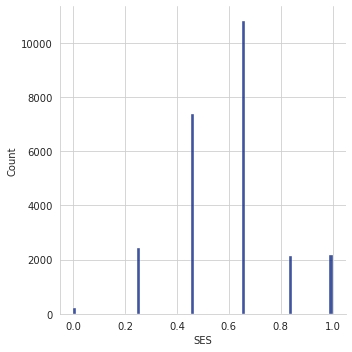

In [34]:
sns.displot(model_df['SES'])

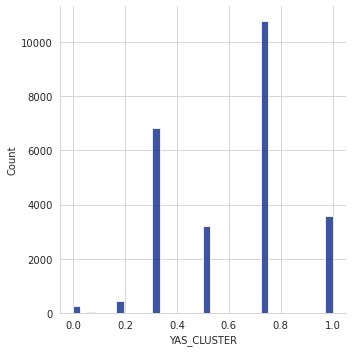

In [35]:
sns.displot(model_df['YAS_CLUSTER'])

In [36]:
# final data for model
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25104 entries, 0 to 25103
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   outletnumber        25104 non-null  float64
 1   SES                 25104 non-null  float64
 2   YAS_CLUSTER         25104 non-null  float64
 3   HANE_BUYUKLUGU      25104 non-null  float64
 4   ZENGINLIK_INDEKSI   25104 non-null  float64
 5   AYLIK_HARCAMA       25104 non-null  float64
 6   ALKOLTUTUN_ORAN     25104 non-null  float64
 7   EGLENCEKULTUR_ORAN  25104 non-null  float64
 8   LOKANTAOTEL_ORAN    25104 non-null  float64
 9   EGITIM              25104 non-null  float64
 10  UNIVERSITE          25104 non-null  float64
 11  KULTUREL            25104 non-null  float64
 12  ORTA_UST            25104 non-null  float64
dtypes: float64(13)
memory usage: 2.5 MB


## Model

In [37]:
# drop columns for final data for model
model_df = model_df.drop(["outletnumber"],axis=1)

In [38]:
hrc_model = AgglomerativeClustering(n_clusters=5, linkage='ward', affinity='euclidean')
hrc_preds = hrc_model.fit_predict(model_df)

In [39]:
model_df["hrc_cluster"] = hrc_preds

In [40]:
df["hrc_cluster"] = hrc_preds

In [41]:
model_df["hrc_cluster"].unique()

array([4, 3, 2, 1, 0])

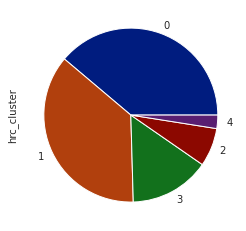

In [42]:
model_df['hrc_cluster'].value_counts().plot(kind='pie')

In [43]:
model_df['hrc_cluster'].value_counts()

0    9751
1    9190
3    3744
2    1794
4     625
Name: hrc_cluster, dtype: int64

## Decision Points

In [44]:
from sklearn.model_selection import train_test_split

x = model_df.drop('hrc_cluster', axis=1)
y = model_df['hrc_cluster']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
dc = DecisionTreeClassifier(criterion="entropy", random_state=42, ) #max feat. bak bakalım
dc.fit(x_train, y_train)
y_pred = dc.predict(x_test)

d_text = tree.export_text(dc)
print(d_text)

|--- feature_1 <= 0.63
|   |--- feature_8 <= 0.50
|   |   |--- feature_5 <= 0.42
|   |   |   |--- feature_6 <= 0.50
|   |   |   |   |--- class: 4
|   |   |   |--- feature_6 >  0.50
|   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- feature_5 >  0.42
|   |   |   |--- feature_10 <= 0.50
|   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_11 >  0.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_9 >  0.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- feature_10 >  0.50
|   |   |   |   |--- class: 1
|   |--- feature_8 >  0.50
|   |   |--- feature_10 <= 0.50
|   |   |   |--- feature_5 <= 0.16
|   |   |   |   |--- class: 4
|   |   |   |--- feature_5 >  0.16
|   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   

In [45]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.9995171997585999

In [46]:
dc.feature_importances_

array([0.        , 0.44038629, 0.        , 0.00082365, 0.        ,
       0.23873388, 0.00498729, 0.04523988, 0.18100795, 0.02476592,
       0.04219127, 0.02186386])

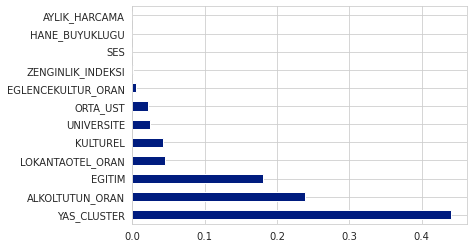

In [47]:
pd.Series(dc.feature_importances_, index=x_train.columns).nlargest(20).plot(kind='barh')

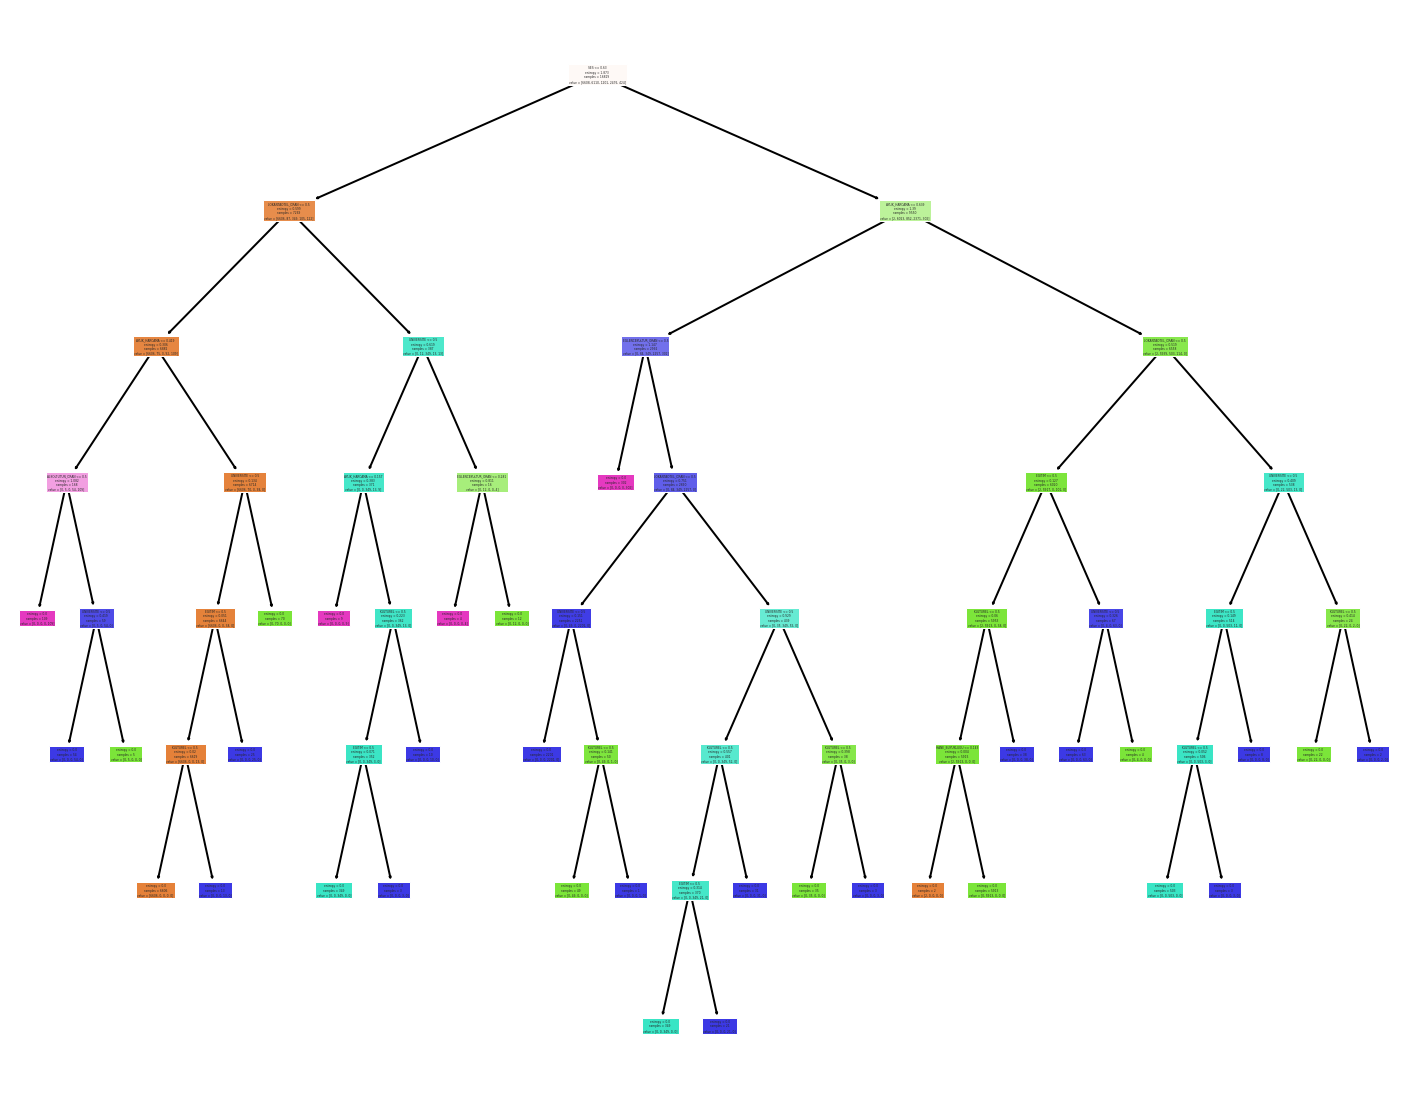

In [48]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dc,
                   feature_names=model_data.columns,
                   filled=True)
for o in _:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(2)
        
plt.show()

Text(0.5, 1.0, 'Hier. Clustering with 2 dimensions')

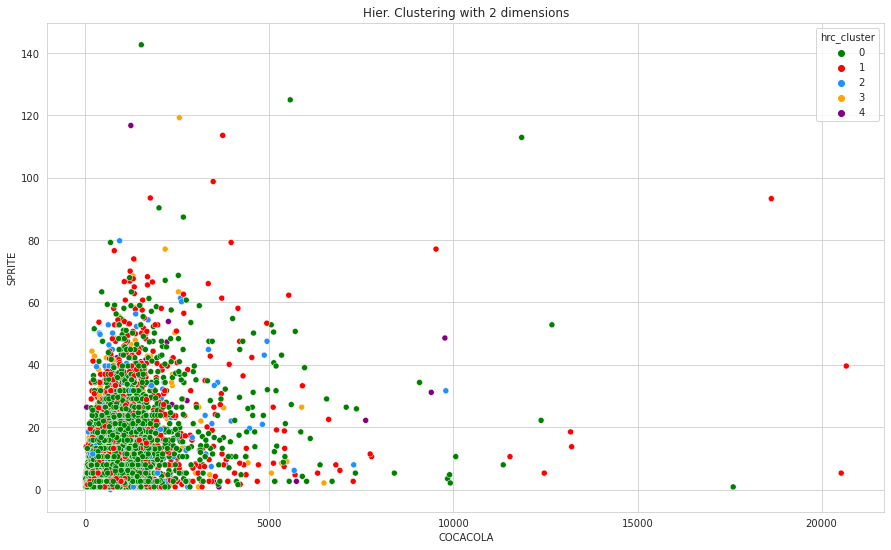

In [49]:
plt.figure(figsize=(15, 9))
sns.scatterplot(x="COCACOLA", y="SPRITE", hue=df['hrc_cluster'], data=df, palette=['green','red','dodgerblue',"orange","purple"])
plt.title('Hier. Clustering with 2 dimensions')


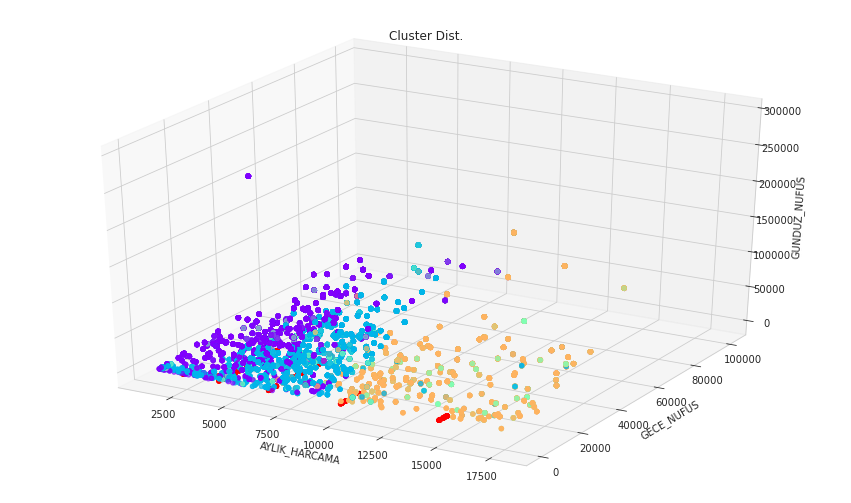

In [50]:
#Plot the clusters obtained using k means
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['AYLIK_HARCAMA'],df['GECE_NUFUS'], df['GUNDUZ_NUFUS'],
                     c=hrc_preds, s=20, cmap="rainbow")


ax.set_title('Cluster Dist.')
ax.set_xlabel('AYLIK_HARCAMA')
ax.set_ylabel('GECE_NUFUS')
ax.set_zlabel('GUNDUZ_NUFUS')
plt.show()

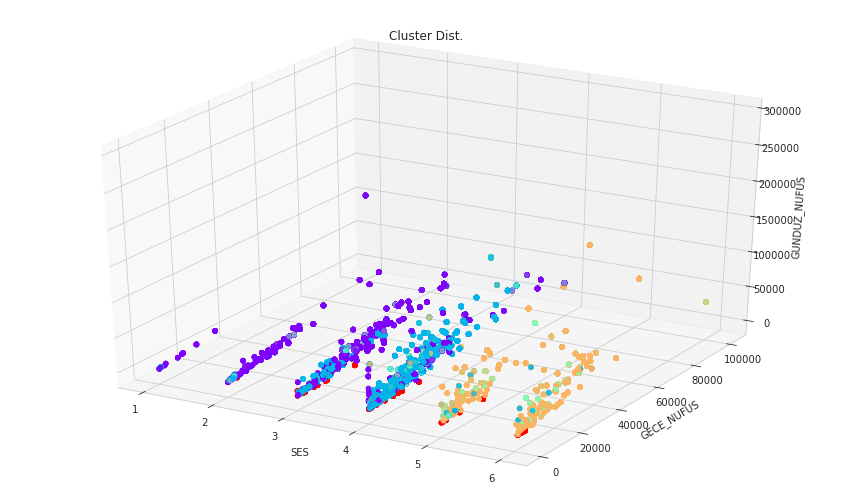

In [51]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['SES'].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1}), df['GECE_NUFUS'], df['GUNDUZ_NUFUS'],
                     c=hrc_preds, s=20, cmap="rainbow")


ax.set_title('Cluster Dist.')
ax.set_xlabel('SES')
ax.set_ylabel('GECE_NUFUS')
ax.set_zlabel('GUNDUZ_NUFUS')
plt.show()

## Results

In [52]:
# extract coordinates
df["x"] = df["geometry"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[1])
df["y"] = df["geometry"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[0])

In [53]:
df["y"] = pd.to_numeric(df["y"], downcast="float")
df["x"] = pd.to_numeric(df["x"], downcast="float")

In [54]:
# Cluster separation
cluster_0 = df.query("hrc_cluster == 0")
cluster_1 = df.query("hrc_cluster == 1")
cluster_2 = df.query("hrc_cluster == 2")
cluster_3 = df.query("hrc_cluster == 3")
cluster_4 = df.query("hrc_cluster == 4")

### General Info.

In [55]:
print("Toplam outlet sayısı : ", df.outletnumber.nunique())

Toplam outlet sayısı :  25104


In [56]:
print("Totaldeki ortalama aylık harcama: ",df['AYLIK_HARCAMA'].mean())

Totaldeki ortalama aylık harcama:  6695.107512746973


In [57]:
print("Totaldeki A,B,C1 kategorisindeki toplam outlet sayısı: ", df.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber.nunique())

Totaldeki A,B,C1 kategorisindeki toplam outlet sayısı:  15113


In [58]:
print("'Genç' kategorisi kapsamındaki toplam outlet sayısı: ", df.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber.nunique())

'Genç' kategorisi kapsamındaki toplam outlet sayısı:  7271


&nbsp;

### Cluster-0

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama düşük.</dd> 
<dd>2. SES kategorisi düşük.</dd>
<dd>3. Gençler en yüksek.</dd>
<dd>4. Yaşlı yok.</dd>
<dd>5. Alkol/Tütün kullanımı yüksek.</dd>
</font>

In [59]:
print("Cluster-0'daki toplam outlet sayısı : ",cluster_0.outletnumber.nunique(), "\n")

print("Cluster-0'ın ortalama aylık harcaması: ",cluster_0['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-0'ın A,B,C1 kategorisindeki outlet oranı: ", '%' ,len(cluster_0.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber)/len(cluster_0.outletnumber)*100, "\n")

print("Cluster-0'ın 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_0.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber)/len(cluster_0.outletnumber)*100, "\n")

print("Cluster-0'ın 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_0.query("YAS_CLUSTER == 'OLD'").outletnumber)/len(cluster_0.outletnumber)*100, "\n")

print("Cluster-0'ın genel Alkol/Tütün oranı: ", '%', (cluster_0.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")


Cluster-0'daki toplam outlet sayısı :  9751 

Cluster-0'ın ortalama aylık harcaması:  4384.042867398216 

Cluster-0'ın A,B,C1 kategorisindeki outlet oranı:  % 24.294944108296583 

Cluster-0'ın 'Genç' kategorisi kapsamındaki outlet yüzdesi:  % 69.23392472566916 

Cluster-0'ın 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi:  % 0.0 

Cluster-0'ın genel Alkol/Tütün oranı:  % 43.73003549245785 



&nbsp;

### Cluster-1

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama ortalama.</dd> 
<dd>2. SES kategorisi epey yüksek.</dd>
<dd>3. Gençler ve yaşlılar az.</dd>
<dd>4. Orta yaş en fazla.</dd>
<dd>5. Alkol/Tütün kullanımı yüksek.</dd>
</font>

In [60]:
print("Cluster-1'deki toplam outlet sayısı : ",cluster_1.outletnumber.nunique(), "\n")

print("Cluster-1'in ortalama aylık harcaması: ",cluster_1['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-1'in A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_1.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber)/len(cluster_1.outletnumber)*100, "\n")

print("Cluster-1'in 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_1.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber)/len(cluster_1.outletnumber)*100, "\n")

print("Cluster-1'in 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_1.query("YAS_CLUSTER == 'OLD'").outletnumber)/len(cluster_1.outletnumber)*100, "\n")

print("Cluster-1'in genel Alkol/Tütün oranı: ", '%', (cluster_1.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

Cluster-1'deki toplam outlet sayısı :  9190 

Cluster-1'in ortalama aylık harcaması:  6505.022198041349 

Cluster-1'in A,B,C1 kategorisindeki outlet oranı:  % 79.29270946681174 

Cluster-1'in 'Genç' kategorisi kapsamındaki outlet yüzdesi:  % 0.9140369967355821 

Cluster-1'in 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi:  % 9.053318824809576 

Cluster-1'in genel Alkol/Tütün oranı:  % 40.59006211180124 



&nbsp;

### Cluster-2

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama epey yüksek.</dd> 
<dd>2. SES kategorisi yüksek.</dd>
<dd>3. Gençler ve yaşlılar az.</dd>
<dd>4. Orta yaş epey fazla.</dd>
<dd>5. Alkol/Tütün kullanımı epey az.</dd>
</font>

In [61]:
print("Cluster-2'deki toplam outlet sayısı : ",cluster_2.outletnumber.nunique(), "\n")

print("Cluster-2'nin ortalama aylık harcaması: ",cluster_2['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-2'nin A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_2.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber)/len(cluster_2.outletnumber)*100, "\n")

print("Cluster-2'nin 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_2.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber)/len(cluster_2.outletnumber)*100, "\n")

print("Cluster-2'nin 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_2.query("YAS_CLUSTER == 'OLD'").outletnumber)/len(cluster_2.outletnumber)*100, "\n")

print("Cluster-2'nin genel Alkol/Tütün oranı: ", '%', (cluster_2.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

Cluster-2'deki toplam outlet sayısı :  1794 

Cluster-2'nin ortalama aylık harcaması:  8119.701783723523 

Cluster-2'nin A,B,C1 kategorisindeki outlet oranı:  % 74.24749163879598 

Cluster-2'nin 'Genç' kategorisi kapsamındaki outlet yüzdesi:  % 19.899665551839465 

Cluster-2'nin 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi:  % 23.299888517279822 

Cluster-2'nin genel Alkol/Tütün oranı:  % 6.8023513753327425 



&nbsp;

### Cluster-3

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama en yüksek.</dd> 
<dd>2. SES kategorisi en yüksek.</dd>
<dd>3. Gençler az.</dd>
<dd>4. Yaşlılar ve orta yaştakiler fazla.</dd>
<dd>5. Alkol/Tütün kullanımı az.</dd>
</font>

In [62]:
print("Cluster-3'deki toplam outlet sayısı : ",cluster_3.outletnumber.nunique(), "\n")

print("Cluster-3'ün ortalama aylık harcaması: ",cluster_3['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-3'ün A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_3.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber)/len(cluster_3.outletnumber)*100, "\n")

print("Cluster-3'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_3.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber)/len(cluster_3.outletnumber)*100, "\n")

print("Cluster-3'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_3.query("YAS_CLUSTER == 'OLD'").outletnumber)/len(cluster_3.outletnumber)*100, "\n")

print("Cluster-3'ün genel Alkol/Tütün oranı: ", '%', (cluster_3.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

Cluster-3'deki toplam outlet sayısı :  3744 

Cluster-3'ün ortalama aylık harcaması:  12473.966079059828 

Cluster-3'ün A,B,C1 kategorisindeki outlet oranı:  % 98.98504273504274 

Cluster-3'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi:  % 1.4155982905982907 

Cluster-3'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi:  % 54.700854700854705 

Cluster-3'ün genel Alkol/Tütün oranı:  % 8.877551020408163 



&nbsp;

### Cluster-4

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama orta.</dd> 
<dd>2. SES kategorisi yüksek.</dd>
<dd>3. Gençler az.</dd>
<dd>4. Yaşlılar ve orta yaştakiler fazla.</dd>
<dd>5. Alkol/Tütün kullanımı yok.</dd>
</font>

In [63]:
print("Cluster-4'deki toplam outlet sayısı : ",cluster_4.outletnumber.nunique(), "\n")

print("Cluster-4'ün ortalama aylık harcaması: ",cluster_4['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-4'ün A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_4.query("SES == 'A' or SES == 'B' or SES == 'C1'").outletnumber)/len(cluster_4.outletnumber)*100, "\n")

print("Cluster-4'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_4.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outletnumber)/len(cluster_4.outletnumber)*100, "\n")

print("Cluster-4'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_4.query("YAS_CLUSTER == 'OLD'").outletnumber)/len(cluster_4.outletnumber)*100, "\n")

print("Cluster-4'ün genel Alkol/Tütün oranı: ", '%', (cluster_4.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

Cluster-4'deki toplam outlet sayısı :  625 

Cluster-4'ün ortalama aylık harcaması:  6839.5984 

Cluster-4'ün A,B,C1 kategorisindeki outlet oranı:  % 67.04 

Cluster-4'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi:  % 4.16 

Cluster-4'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi:  % 43.36 

Cluster-4'ün genel Alkol/Tütün oranı:  % 0.0 



&nbsp;

In [64]:
breakhere

NameError: name 'breakhere' is not defined

<h1><center>Cluster-0</center></h1>

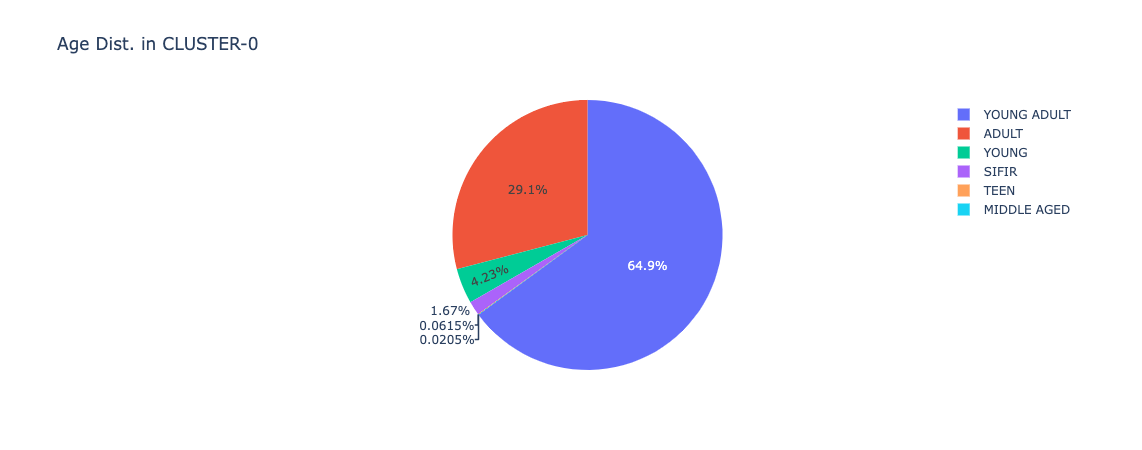

In [88]:
pie=cluster_0.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-0')

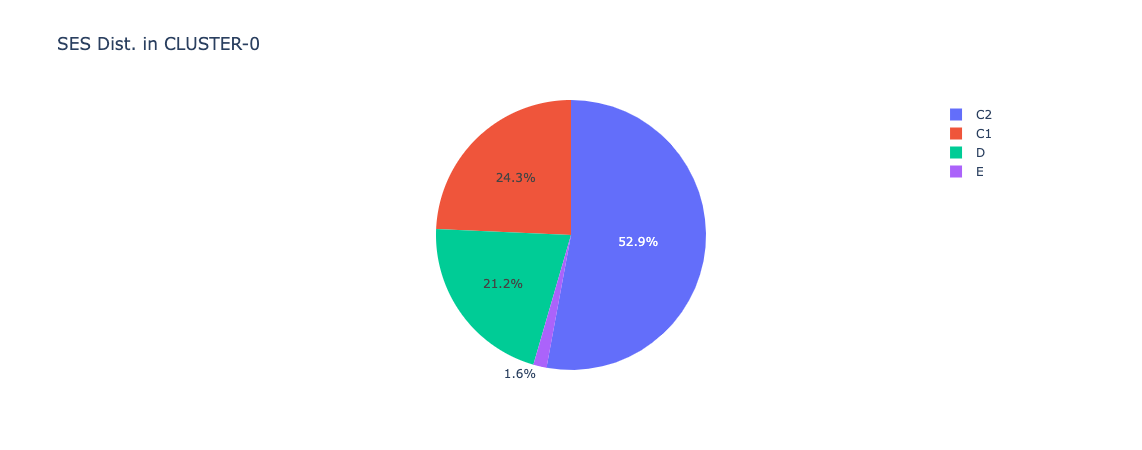

In [89]:
pie=cluster_0.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-0')

In [67]:
yas_brand_0 = cluster_0[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [68]:
yas_brand_0

,YAS_CLUSTER,BURN,CAPPY,CC_LIGHT,CC_NO_SUGER,COCACOLA,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,ADULT,7261.168,171265.031,1151.357,35995.967,1715905.547,0.0,10059.725,51596.508,0.000,280294.753,43629.050,16664.435,234.654,6678.861,13727.215
1,MIDDLE AGED,4.224,227.973,0.000,30.705,1400.606,0.0,1.690,34.514,0.000,256.654,7.460,0.000,0.000,11.830,8.559
2,SIFIR,652.252,12159.937,190.349,2052.451,77604.595,0.0,867.815,3971.580,4.182,9017.400,2913.133,445.648,7.399,1046.701,407.312
3,TEEN,23.760,370.155,1.585,33.811,2004.054,0.0,9.295,48.599,0.000,79.359,53.333,46.263,1.057,7.819,0.000
4,YOUNG,1609.589,24381.444,144.939,4019.427,275860.115,0.0,2060.110,6409.992,0.000,63686.399,7423.858,1128.498,22.197,511.967,1617.999
5,YOUNG ADULT,17453.851,378089.163,1535.022,68432.740,3799590.716,0.0,25978.680,135147.557,5.576,651100.725,114177.239,22152.679,498.904,10029.210,32444.575


In [69]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_0 = yas_brand_0.query("YAS_CLUSTER=='YOUNG'").groupby("YAS_CLUSTER").sum().T

In [70]:
yas_cluster_0

YAS_CLUSTER,YOUNG
BURN,1609.589
CAPPY,24381.444
CC_LIGHT,144.939
CC_NO_SUGER,4019.427
COCACOLA,275860.115
COCACOLA_ENERGY,0.000
DAMLA_MINERA,2060.110
DAMLA_WATER,6409.992
EXOTIC,0.000
FANTA,63686.399


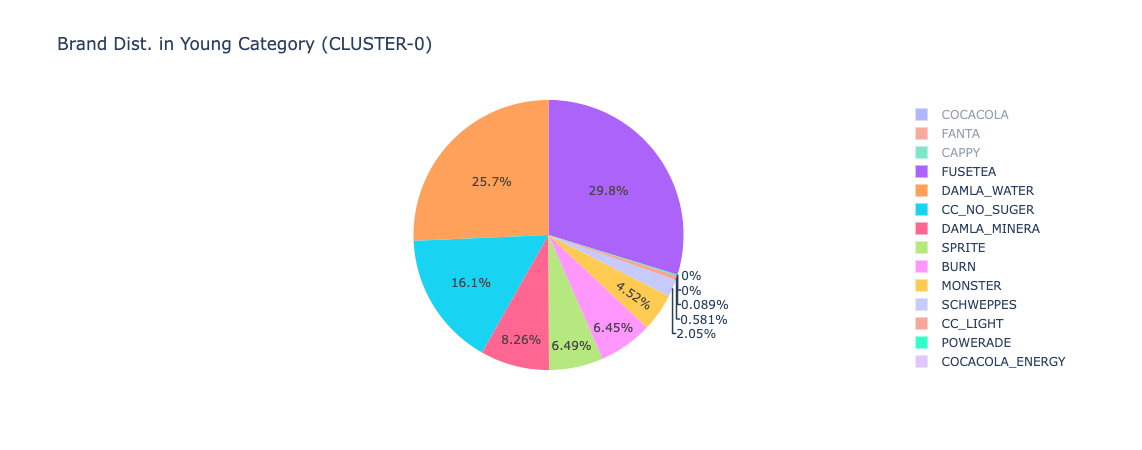

In [71]:
fig = px.pie(yas_cluster_0.reset_index(), values='YOUNG', names="index", title='Brand Dist. in Young Category (CLUSTER-0)')
fig.show()

In [85]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_teen_0 = yas_brand_0.query("YAS_CLUSTER=='TEEN'").groupby("YAS_CLUSTER").sum().T

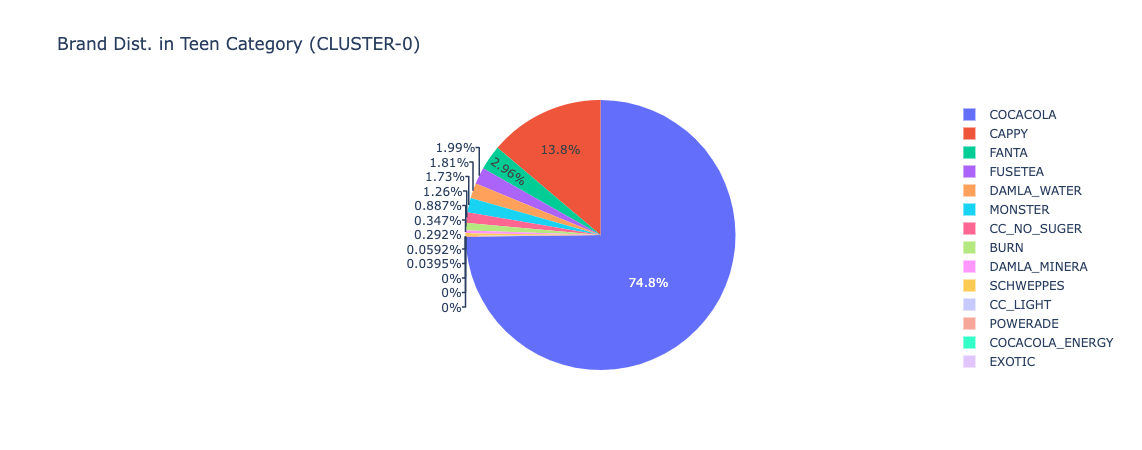

In [87]:
fig = px.pie(yas_cluster_teen_0.reset_index(), values='TEEN', names="index", title='Brand Dist. in Teen Category (CLUSTER-0)')
fig.show()

<h1><center>Cluster-1</center></h1>

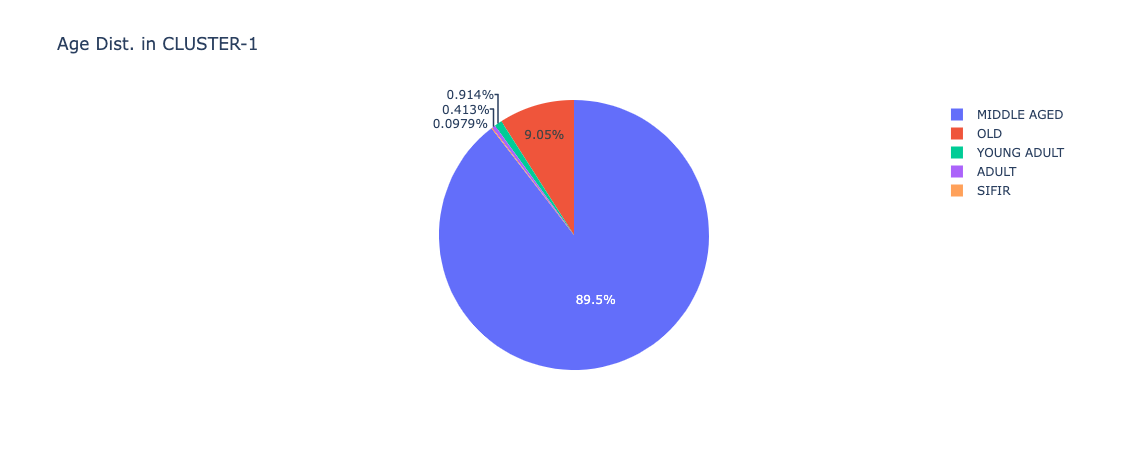

In [90]:
pie=cluster_1.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-1')

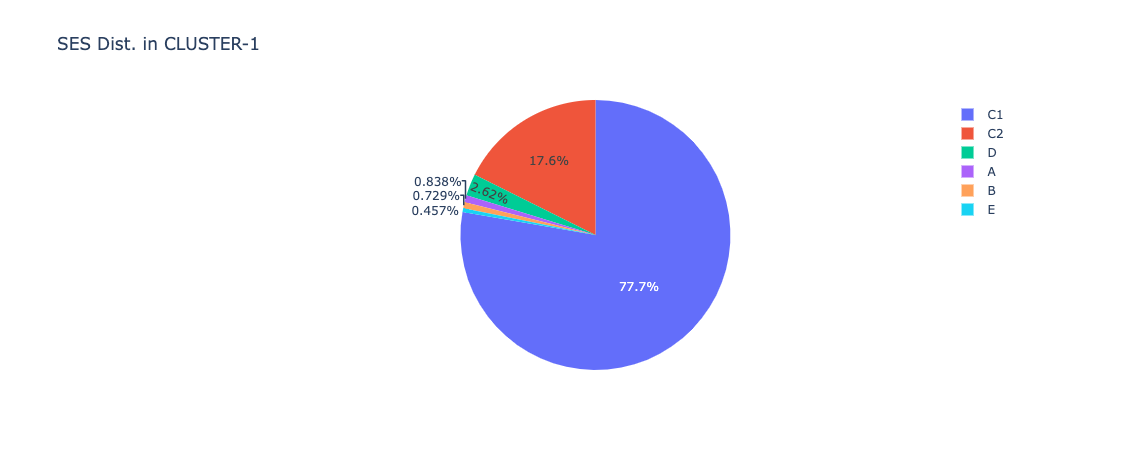

In [92]:
pie=cluster_1.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-1')

In [74]:
yas_brand_1 = cluster_1[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [93]:
yas_cluster_1 = yas_brand_1.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

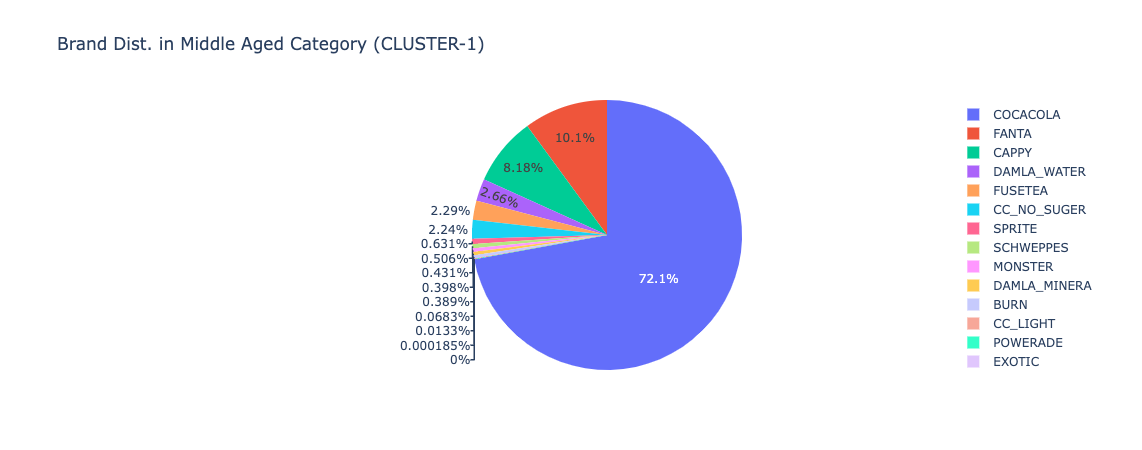

In [96]:
fig = px.pie(yas_cluster_1.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Aged Category (CLUSTER-1)')
fig.show()

<h1><center>Cluster-2</center></h1>

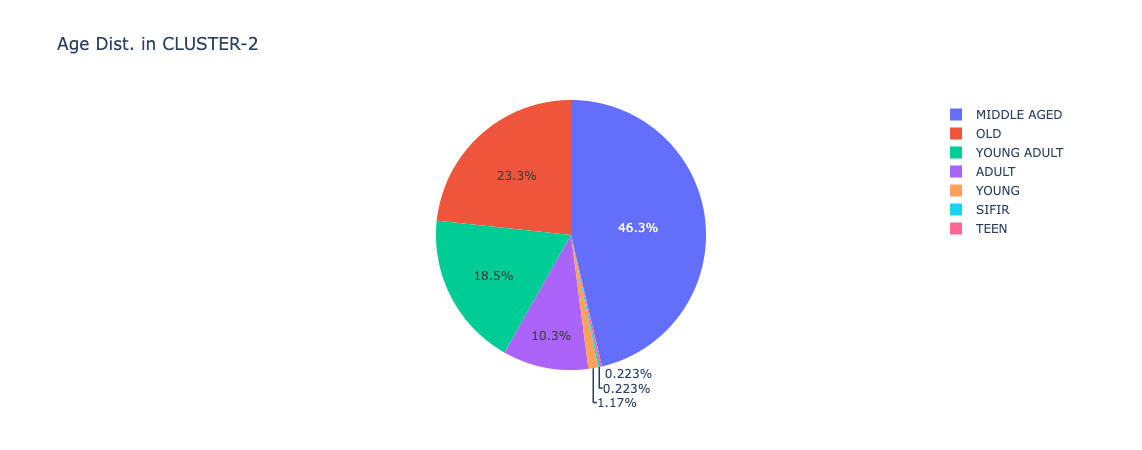

In [97]:
pie=cluster_2.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-2')

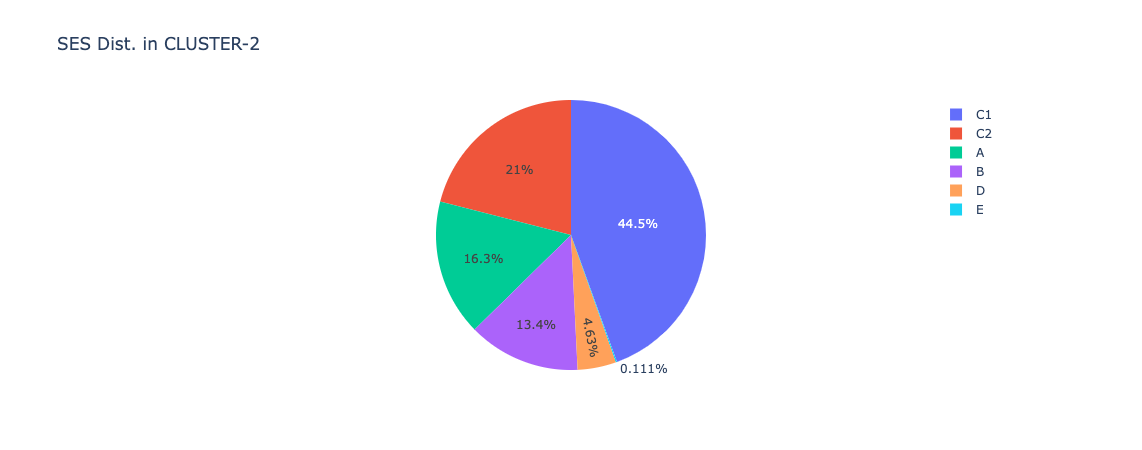

In [98]:
pie=cluster_2.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-2')

In [79]:
yas_brand_2 = cluster_2[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [99]:
yas_brand_2

,YAS_CLUSTER,BURN,CAPPY,CC_LIGHT,CC_NO_SUGER,COCACOLA,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,ADULT,565.691,11625.359,235.571,3058.314,90945.280,0.0,678.535,2798.129,0.697,15152.636,2672.040,1426.279,17.969,640.649,966.513
1,MIDDLE AGED,2637.325,52508.921,929.373,14732.143,356716.992,0.0,2165.735,17215.756,1.394,43588.406,13889.919,3352.872,104.643,3812.042,3641.008
2,OLD,1528.980,28146.646,1881.053,14866.255,139919.405,0.0,795.145,14548.099,8.364,13204.429,5593.346,1767.849,68.705,6073.868,1080.032
3,SIFIR,25.352,215.756,1.395,55.577,1192.650,0.0,9.295,47.192,0.000,95.206,78.385,16.842,0.000,30.435,4.332
4,TEEN,17.957,264.216,4.185,31.611,1200.019,0.0,12.675,97.242,0.000,44.908,24.634,6.921,0.000,23.884,5.917
5,YOUNG,57.032,1790.111,1.395,147.902,13689.052,0.0,37.180,266.607,0.000,2742.738,362.310,176.969,0.000,50.712,133.891
6,YOUNG ADULT,937.000,21466.380,53.829,5864.536,183699.901,0.0,1540.435,8867.110,0.000,30444.365,5750.824,826.617,40.166,668.775,1528.707


In [115]:
yas_cluster_2 = yas_brand_2.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

In [116]:
yas_cluster_2

YAS_CLUSTER,MIDDLE AGED
BURN,2637.325
CAPPY,52508.921
CC_LIGHT,929.373
CC_NO_SUGER,14732.143
COCACOLA,356716.992
COCACOLA_ENERGY,0.000
DAMLA_MINERA,2165.735
DAMLA_WATER,17215.756
EXOTIC,1.394
FANTA,43588.406


In [105]:
yas_brand_2_sum = cluster_2[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].sum().reset_index()

In [106]:
yas_brand_2_sum.rename({0: "value"}, inplace=True, axis=1)
yas_brand_2_sum = yas_brand_2_sum.iloc[1: , :]

In [110]:
yas_brand_2_sum

,index,value
1,BURN,5769.337
2,CAPPY,116017.389
3,CC_LIGHT,3106.801
4,CC_NO_SUGER,38756.338
5,COCACOLA,787363.299
6,COCACOLA_ENERGY,0.0
7,DAMLA_MINERA,5239.0
8,DAMLA_WATER,43840.135
9,EXOTIC,10.455
10,FANTA,105272.688


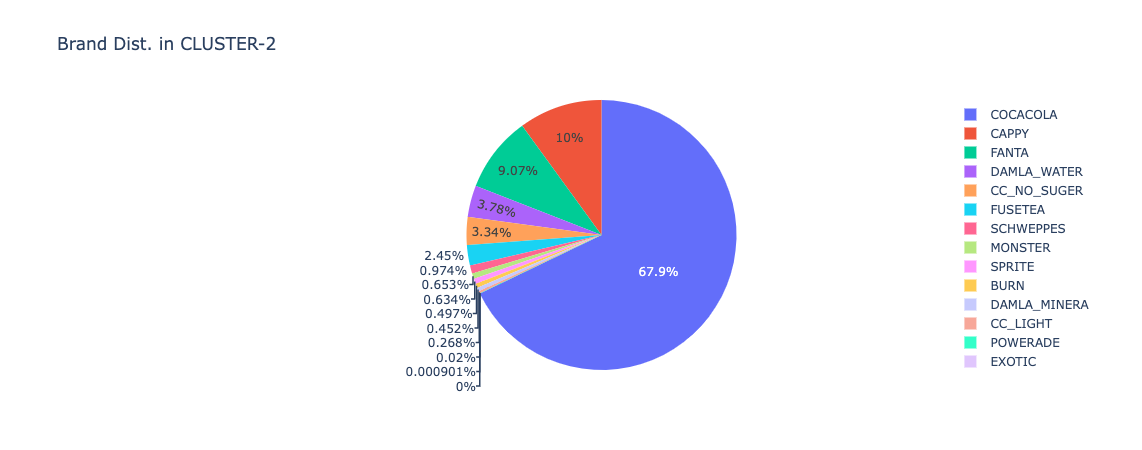

In [111]:
fig = px.pie(yas_brand_2_sum, values='value', names="index", title='Brand Dist. in CLUSTER-2')
fig.show()

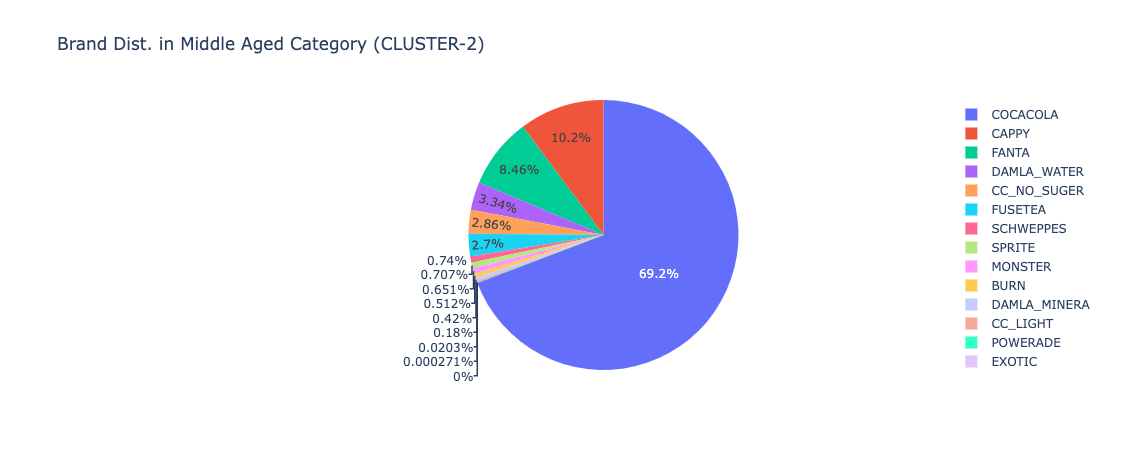

In [117]:
fig = px.pie(yas_cluster_2.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Aged Category (CLUSTER-2)')
fig.show()

In [118]:
yas_cluster_2_old = yas_brand_2.query("YAS_CLUSTER=='OLD'").groupby("YAS_CLUSTER").sum().T

In [119]:
yas_cluster_2_old

YAS_CLUSTER,OLD
BURN,1528.980
CAPPY,28146.646
CC_LIGHT,1881.053
CC_NO_SUGER,14866.255
COCACOLA,139919.405
COCACOLA_ENERGY,0.000
DAMLA_MINERA,795.145
DAMLA_WATER,14548.099
EXOTIC,8.364
FANTA,13204.429


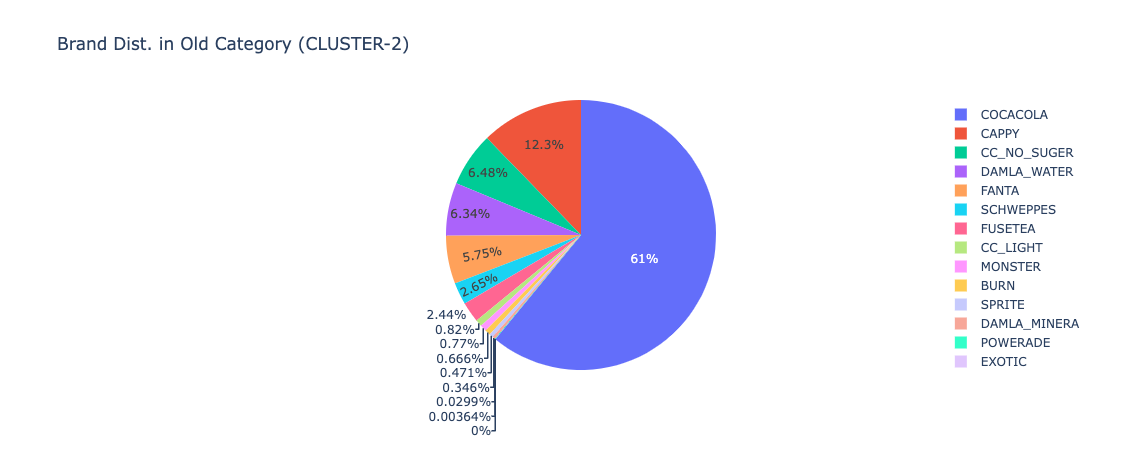

In [120]:
fig = px.pie(yas_cluster_2_old.reset_index(), values='OLD', names="index", title='Brand Dist. in Old Category (CLUSTER-2)')
fig.show()

<h1><center>Cluster-3</center></h1>

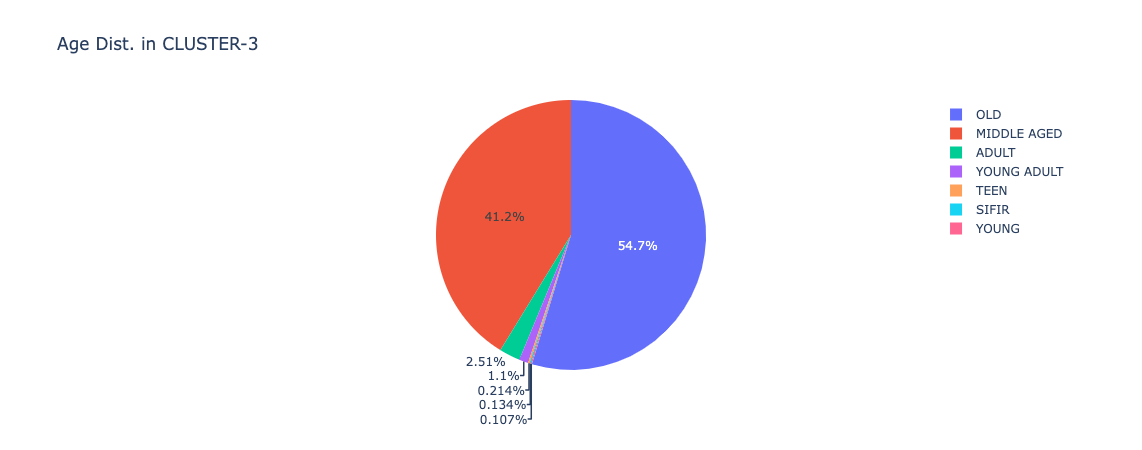

In [121]:
pie=cluster_3.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-3')

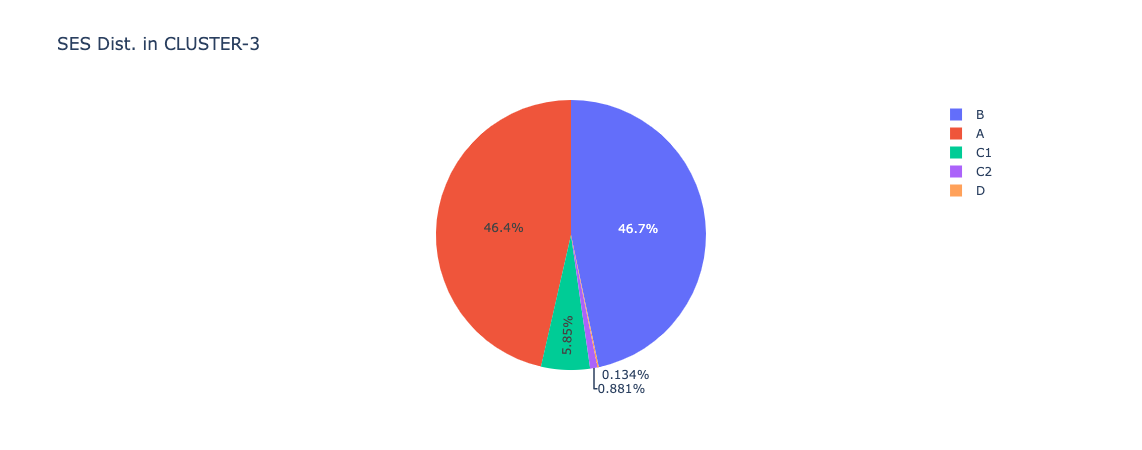

In [122]:
pie=cluster_3.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-3')

In [124]:
yas_brand_3 = cluster_3[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [125]:
yas_brand_3

,YAS_CLUSTER,BURN,CAPPY,CC_LIGHT,CC_NO_SUGER,COCACOLA,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,ADULT,325.887,6792.175,201.607,2339.220,31079.136,0.0,224.770,1212.214,1.394,3155.472,1782.966,395.336,15.855,989.824,359.604
1,MIDDLE AGED,5127.801,95413.073,2888.723,47237.613,589419.225,0.0,4044.170,32485.066,3.485,62586.265,25518.345,6399.111,319.214,12334.432,6001.892
2,OLD,5786.156,119048.962,15684.757,97358.195,567884.079,0.0,3919.955,42350.778,33.456,43310.219,27714.862,6908.093,255.794,29812.026,5306.475
3,SIFIR,19.013,407.320,5.960,65.892,718.864,0.0,17.745,203.592,0.000,47.018,98.777,13.842,0.000,19.658,21.452
4,TEEN,25.355,662.757,16.253,131.390,3953.864,0.0,5.070,400.115,0.000,274.084,66.631,26.285,1.057,182.991,42.798
5,YOUNG,12.673,253.016,1.395,17.136,1776.295,0.0,10.140,12.679,0.697,346.601,53.673,13.842,0.000,20.076,19.339
6,YOUNG ADULT,248.284,4505.005,69.633,616.110,23992.451,0.0,99.710,1000.196,0.000,2528.460,1216.969,247.368,6.342,250.185,310.163


In [126]:
yas_cluster_3 = yas_brand_3.query("YAS_CLUSTER=='OLD'").groupby("YAS_CLUSTER").sum().T

In [127]:
yas_cluster_3

YAS_CLUSTER,OLD
BURN,5786.156
CAPPY,119048.962
CC_LIGHT,15684.757
CC_NO_SUGER,97358.195
COCACOLA,567884.079
COCACOLA_ENERGY,0.000
DAMLA_MINERA,3919.955
DAMLA_WATER,42350.778
EXOTIC,33.456
FANTA,43310.219


In [128]:
yas_brand_3_sum = cluster_3[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].sum().reset_index()

In [129]:
yas_brand_3_sum.rename({0: "value"}, inplace=True, axis=1)
yas_brand_3_sum = yas_brand_3_sum.iloc[1: , :]

In [130]:
yas_brand_3_sum

,index,value
1,BURN,11545.169
2,CAPPY,227082.308
3,CC_LIGHT,18868.328
4,CC_NO_SUGER,147765.556
5,COCACOLA,1218823.914
6,COCACOLA_ENERGY,0.0
7,DAMLA_MINERA,8321.56
8,DAMLA_WATER,77664.64
9,EXOTIC,39.032
10,FANTA,112248.119


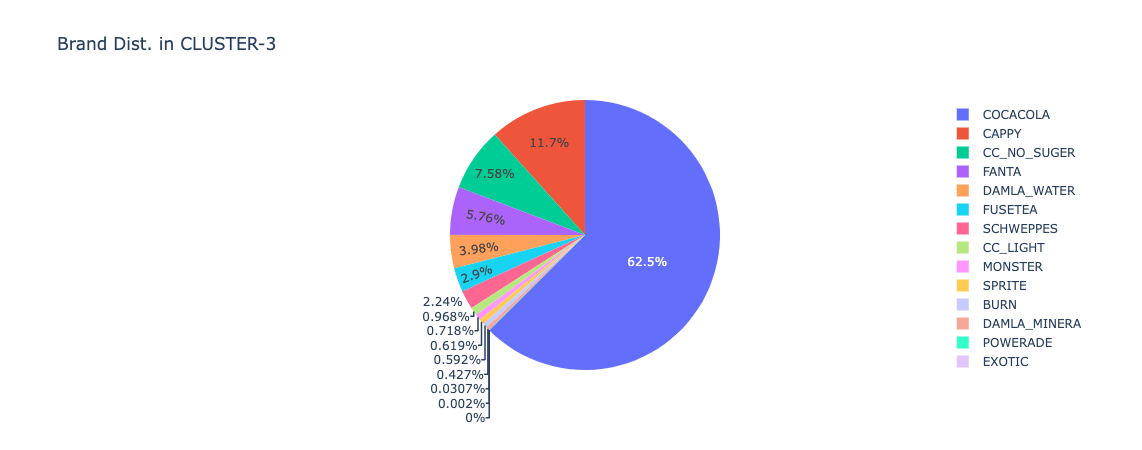

In [131]:
fig = px.pie(yas_brand_3_sum, values='value', names="index", title='Brand Dist. in CLUSTER-3')
fig.show()

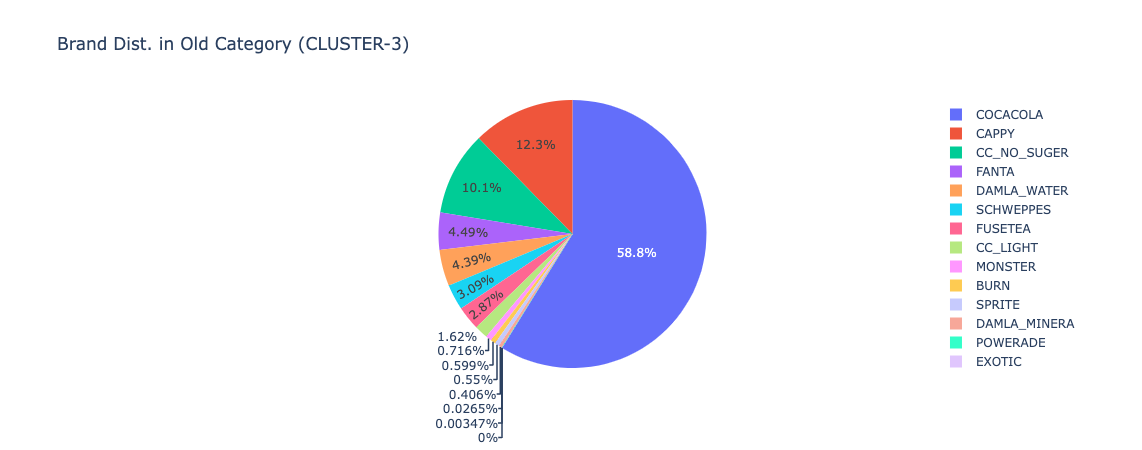

In [132]:
fig = px.pie(yas_cluster_3.reset_index(), values='OLD', names="index", title='Brand Dist. in Old Category (CLUSTER-3)')
fig.show()

In [134]:
yas_cluster_3_mid = yas_brand_3.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

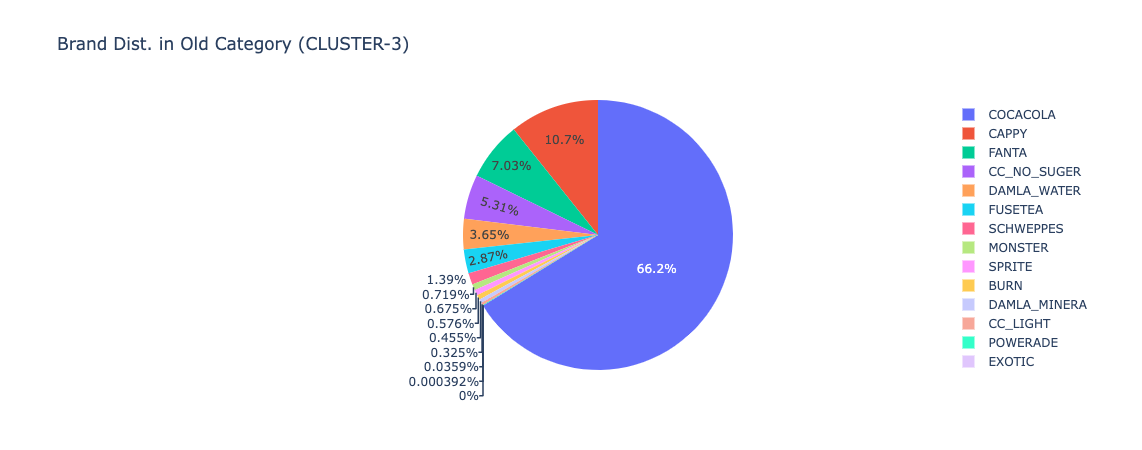

In [137]:
fig = px.pie(yas_cluster_3_mid.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Old Category (CLUSTER-3)')
fig.show()

<h1><center>Cluster-4</center></h1>

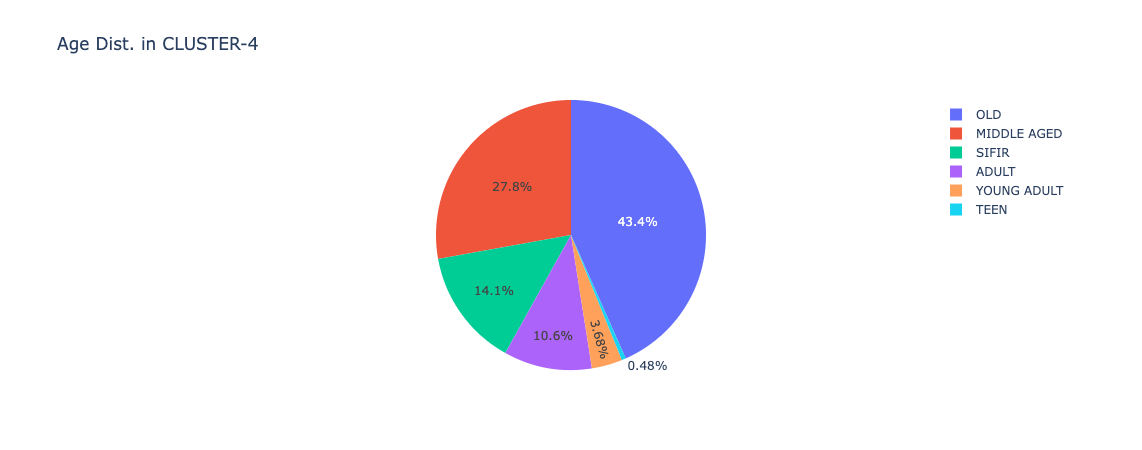

In [138]:
pie=cluster_4.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-4')

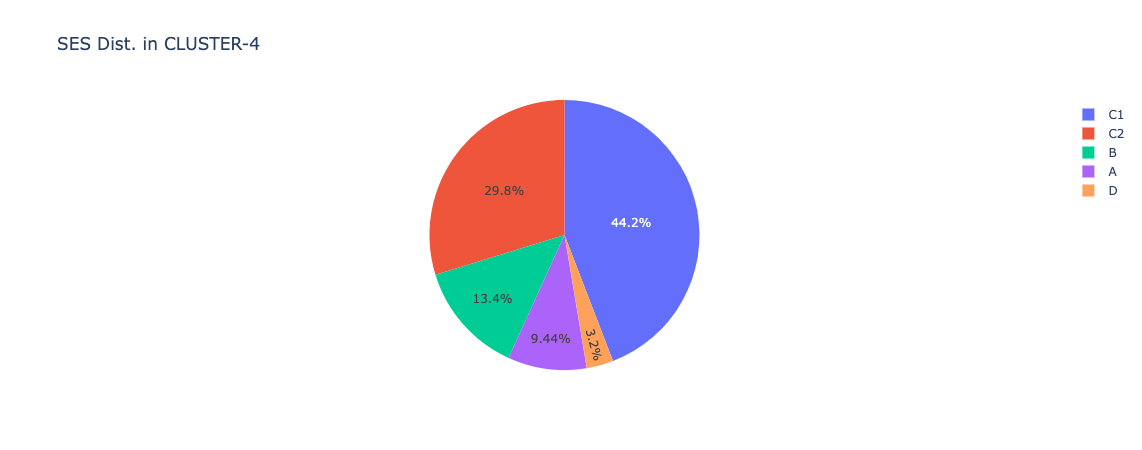

In [139]:
pie=cluster_4.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-4')

In [140]:
yas_brand_4 = cluster_4[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'            
,'CC_NO_SUGER'         
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [141]:
yas_brand_4

,YAS_CLUSTER,BURN,CAPPY,CC_LIGHT,CC_NO_SUGER,COCACOLA,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,ADULT,180.106,7101.759,18.070,796.026,78900.129,0.0,147.875,345.155,0.000,11198.961,793.379,814.574,0.000,169.030,630.035
1,MIDDLE AGED,312.661,11509.600,60.550,2273.350,91448.423,0.0,307.580,6231.911,0.000,12017.785,2508.146,314.153,2.114,433.160,1126.403
2,OLD,698.165,16672.658,703.207,6698.736,79314.567,0.0,698.815,7687.836,4.879,7812.837,3293.432,791.581,17.969,2964.280,560.455
3,SIFIR,491.653,26821.811,246.868,1813.086,32875.785,0.0,359.970,4219.727,9.758,4150.127,3084.207,3183.922,7.399,1127.684,222.024
4,TEEN,5.808,181.479,2.790,32.629,543.108,0.0,9.295,7.748,0.000,64.770,78.929,8.114,0.000,10.143,3.487
5,YOUNG ADULT,64.440,1585.353,6.678,127.247,10678.990,0.0,76.050,237.383,0.000,1421.630,240.269,65.864,5.285,22.611,136.324


In [142]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_4 = yas_brand_4.query("YAS_CLUSTER=='OLD'").groupby("YAS_CLUSTER").sum().T

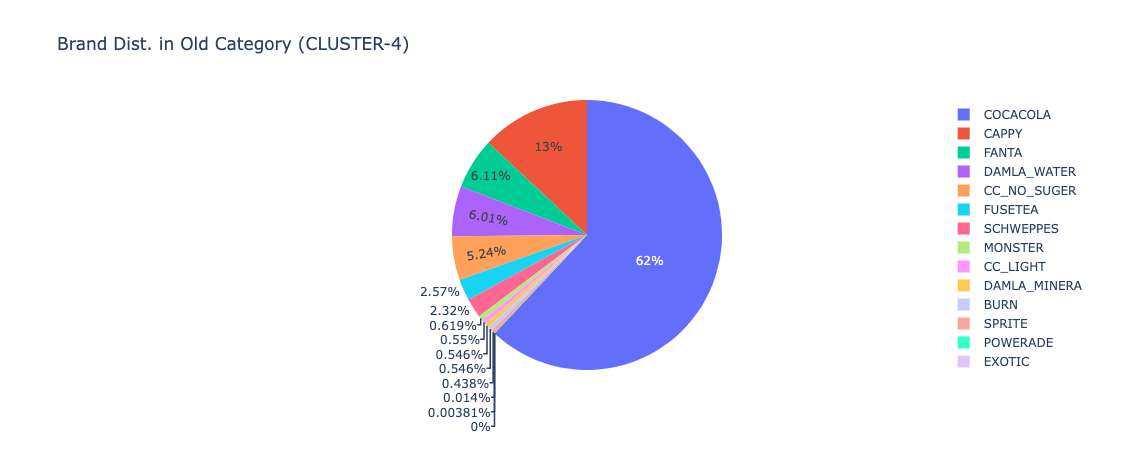

In [144]:
fig = px.pie(yas_cluster_4.reset_index(), values='OLD', names="index", title='Brand Dist. in Old Category (CLUSTER-4)')
fig.show()

In [146]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_mid_4 = yas_brand_4.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

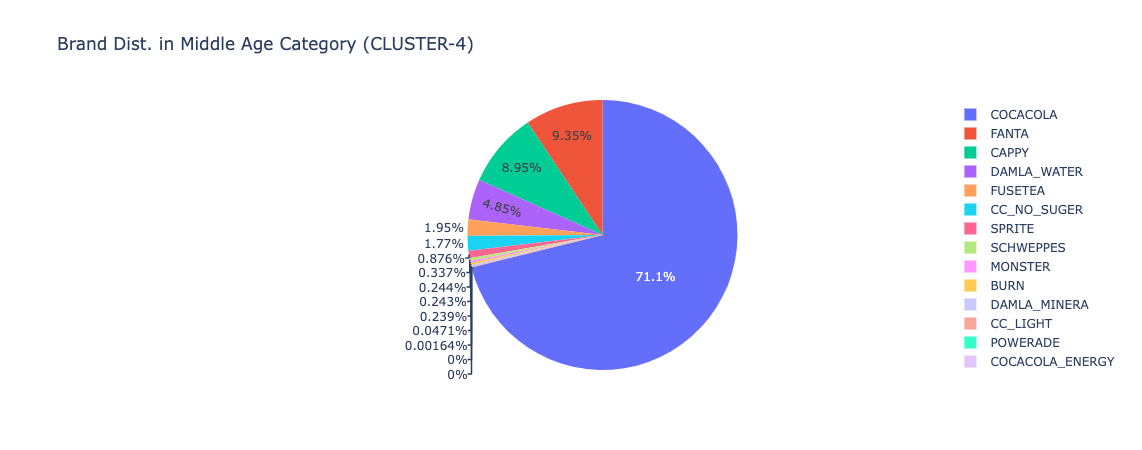

In [147]:
fig = px.pie(yas_cluster_mid_4.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Age Category (CLUSTER-4)')
fig.show()

----

In [ ]:
stophere

In [ ]:
# bigquery'e tabloyu ekleme
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

client = bigquery.Client()

table_id = "coca-cola-data-lake.predictive_order.shopper_profile_hier_clusters" 

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("outletname", bigquery.enums.SqlTypeNames.STRING),
    ],  write_disposition="WRITE_TRUNCATE"
)

job = client.load_table_from_dataframe(df, table_id, job_config=job_config)  
job.result()  

table = client.get_table(table_id)  
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))